<h3>Imports and classes</h3>

In [1]:
#!/usr/bin/env python
# coding: utf-8

import warnings
import statistics
from random import sample
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import QuantileTransformer

# Sklearn imports

from sklearn.utils import shuffle
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold

# Different machine learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import average_precision_score


class IuPred:
    '''
    Needs description.
    '''    
    def __init__(self, glob, short, long):
        self.glob = glob
        self.short = short
        self.long = long


class HydroPhobicIndex:
    '''
    Needs description.
    '''
    def __init__(self, hpilist):
        self.hpilist = hpilist

In [2]:
pd.__version__

'0.23.4'

<h3>Functions</h3>

In [3]:
def get_feature_importances(df, clf):
    '''
    Needs description.
    '''    
    fi = clf.feature_importances_
    fi = pd.DataFrame(fi).transpose()
    fi.columns = df.columns[1:]
    fi = fi.melt()
    fi = fi.sort_values('value', ascending=False)
    fi = fi.loc[fi['value'] > 0.0]
    return fi

In [4]:
def select_testing_data(df, instance, ratio=1, info_columns=['protein_name', 'sequence'], random=False):
    '''
    Class that equalizes the data based on the number of positives.
    :param df: dataframe with all the features and instance
    :param instance: string of instance columns
    :param ratio: ratio of how many negatives should be added (2 = twice as much negative)
    :param random: bool which gives a random test set with both instances randomly picked.
    :return: 'out' dataframe with new data, and 'df_info' dataframe with the information of 
    protein name and sequence.
    '''
    pos = df.loc[df[instance] == 1]
    neg_index = df.loc[df[instance] == 0].index
    negsubset_index = sample(set(neg_index), len(pos) * ratio)
    if random:
        possubset_index = sample(set(df.index), len(pos))
        negsubset_index = sample(set(df.index), len(pos))
        pos = df.loc[possubset_index]
        pos[instance] = pos[instance] = 1
    neg = df.loc[negsubset_index]
    out = pos.append(neg)
    out = out.reset_index(drop=True)
    df_info = out[info_columns]
    out = out.drop(labels=info_columns, axis=1)
    return out, df_info


def calculate_performance(clf, X_test, y_test):
    '''
    Needs description.
    '''    
    prediction = clf.predict(X_test)
    correctness = prediction == y_test
    distribution = correctness.value_counts(True)
    return distribution


def train_model(data, clf, instance):
    df, df_info = select_testing_data(data, instance, ratio=1, random=False)
    X_train, X_test, y_train, y_test = train_test_split(df.drop(instance, axis=1),
                                                        df[instance],
                                                        test_size=0.5,
                                                        random_state=0
                                                        )
    clf = clf.fit(X_train, y_train)
    return clf, X_test, y_test


def get_prc_auc(clf, X_test, y_test, ratio, plot=True):
    '''
    Function that plots the precision recall curve.
    :params: 
    :param clf: Randomforest classifier.
    :param X_test: Samples with the features.
    :param y-test: Classifier of the samples. 
    '''
    from sklearn.metrics import auc
    probs = clf.predict_proba(X_test)
    probs = probs[:, 1]
    yhat = clf.predict(X_test)
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, probs)    
    auc = auc(recall, precision)
    if plot:
        plot_prc(probs, y_test, yhat, auc, precision, recall, thresholds, ratio)
    return auc


def plot_prc(probs, y_test, yhat, auc, precision, recall, thresholds, ratio):
    f1 = f1_score(y_test, yhat)
    ap = average_precision_score(y_test, probs)
    cutoff = 1 / (ratio + 1)
    plt.plot([0, 1], [cutoff, cutoff], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.',
             label='PRC curve (area = %0.2f)' % auc)
    # add labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision recall curve')
    plt.legend(loc="lower left")
    sns.despine()
    # show the plot
    plt.show()


def get_roc_auc(clf, X_test, y_test, plot=True):
    '''
    Needs description.
    '''    
    probs = clf.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    auc = roc_auc_score(y_test, probs)
    # print('AUC: %.3f' % auc)
    # calculate roc curve        
    if plot:
        plot_roc(y_test, probs, auc)
    return auc


def plot_roc(y_test, probs, auc):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(fpr, tpr, marker='.',
             label='ROC curve (area = %0.2f)' % auc)
    # add labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    sns.despine()
    # show the plot
    plt.show()


def average(l):
    return sum(l) / len(l)

<h1>Import data and specify instance</h1>

In [5]:
path = 'out\\human_llps.pkl'
instance = 'llps'

In [6]:
data = pd.read_pickle(path)
data = data.drop(['iupred', 'HydroPhobicIndex', 'uniprot_id'], axis=1)
data = data.fillna(value=0)
print(data.shape)
print('Number of phase separating proteins in dataset: '+str(data.loc[data[instance] == 1].shape[0]))

(20408, 75)
Number of phase separating proteins in dataset: 58


In [6]:
# data.loc[data['llps'] == 1].sort_values('length')['length']

<h3>Filter data</h3>

In [7]:
data = data.loc[(data['length'] >= 100) & (data['length'] <= 3000)]
data = data.reset_index(drop=True)
data.shape

(19549, 75)

<h1>1. Data processing and feature selection </h1>

<h3> 1.1 Pre processing </h3>

In [8]:
def preprocess_data(df, scaler):
    info = df.select_dtypes(include=['object'])
    y = df[instance]
    X = df.drop([instance], axis=1)
    X = X._get_numeric_data()
    columns = X.columns
    
    X = scaler.fit_transform(X)    
    X = pd.DataFrame(X, columns=columns)
    X[instance] = y
    X = X.merge(info, how='outer', left_index=True, right_index=True)    
    return X

<h3> 1.2 remove features that correlate with eachother</h3>

In [9]:
def remove_correlating_features(df, cutoff=.95):
    # Set matplotlib parameters
    sns.set(rc={'figure.figsize':(8,6)})
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    
    print('Correlation: Features before %s' % df.shape[1])
    
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > cutoff)]
    # Drop features
    df = df.drop(to_drop, axis=1)
    
    
    print('Correlation: Features after %s' % df.shape[1])
    
    # Plot heatmap and added xticklabels and yticklabels parameters to plot every label
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    #sns.set(font_scale=0.6)
    sns.heatmap(data=df.corr(), cmap=sns.color_palette("coolwarm", 20), vmin=-1, vmax=1, xticklabels=1, yticklabels=1)
    plt.savefig('Heatmap_after_correlation.pdf', transparent=True)
    plt.show()
    return df

<h3>1.3 Removing features with low variance</h3>

In [10]:
def varianceSelection(df, threashold=.8):
    if not isinstance(df, pd.core.frame.DataFrame):
        logger.error('[%s] : [ERROR] Variance selection only possible on Dataframe not %s',
                                     datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'), type(df))
        sys.exit(1)
    sel = VarianceThreshold(threshold=(threashold * (1 - threashold)))
    sel.fit_transform(df)
    return df[[c for (s, c) in zip(sel.get_support(), df.columns.values) if s]]


def filter_low_variance(df, non_feature_columns, variance_cutoff=.8):
    df_variancetreshold = varianceSelection(df.drop(non_feature_columns, axis=1), variance_cutoff)
    for col in non_feature_columns:
        df_variancetreshold[col] = df[col]
    return df_variancetreshold


def remove_low_variance_features(df, variance_cutoff):
    print('Low varience: Features before %s' % df.shape[1])
    non_feature_columns = ['protein_name', 'sequence', 'llps']
    df_variance = filter_low_variance(df, non_feature_columns, variance_cutoff)
    print('Low varience: Features after  %s' % df_variance.shape[1])
    
    # Set matplotlib parameters
    sns.set(rc={'figure.figsize':(8,6)})
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    
    # Plot heatmap and added xticklabels and yticklabels parameters to plot every label
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    #sns.set(font_scale=0.6)
    sns.heatmap(data=df_variance.corr(), cmap=sns.color_palette("coolwarm", 20), vmin=-1, vmax=1, xticklabels=1, yticklabels=1)
    plt.savefig('Heatmap_after_low_variance.pdf', transparent=True)
    plt.show()
    return df_variance

<h3>1.4 Recursive feature elimination</h3>

In [39]:
# Feature_selection.RFE(estimator[, …])	Feature ranking with recursive feature elimination.

<h1>2 Data visualization</h1>

<h3>2.1 PCA</h3>

In [11]:
from sklearn.decomposition import PCA
def plot_pca(df, title=''):
    # Set matplotlib parameters
    sns.set(rc={'figure.figsize':(8,6)})
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(df.drop(['sequence', 'protein_name'],axis=1))
    pca_df = pd.DataFrame(X_pca, columns=['component1', 'component2'])
    pca_df['protein_name'] = df['protein_name']
    pca_df['llps'] = df.reset_index()['llps']


    sns.scatterplot(data=pca_df.loc[pca_df['llps'] == 0],
                    x = 'component1',
                    y = 'component2',
                    alpha = .5,
                    color = '#AEB6BF',
                    rasterized=True,
                   )
    sns.scatterplot(data=pca_df.loc[pca_df['llps'] == 1],
                    x = 'component1',
                    y = 'component2',
                    alpha = 1,
                    color = '#CD6155',                
                   )
    
    
    # print(pca_df.loc[(pca_df['llps'] == 1) & (pca_df['component1'] >= 650)])
    
    plt.ylabel('Component1 (' + str(round(pca.explained_variance_ratio_[0] * 100, 2)) + '%)')
    plt.xlabel('Component2 (' + str(round(pca.explained_variance_ratio_[1] * 100, 2)) + '%)')
    plt.title(title)
    plt.savefig('PCA_plot.pdf', transparent=True)
    plt.show()

Correlation: Features before 75
Correlation: Features after 68


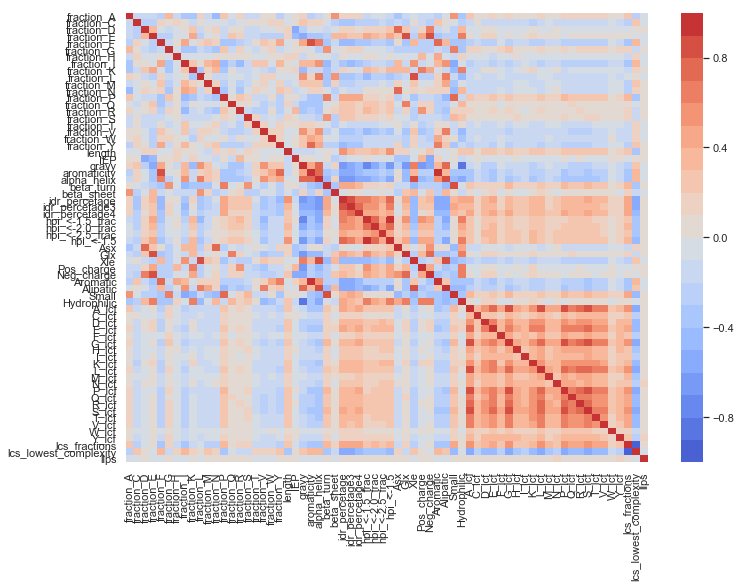

Low varience: Features before 68
Low varience: Features after  58


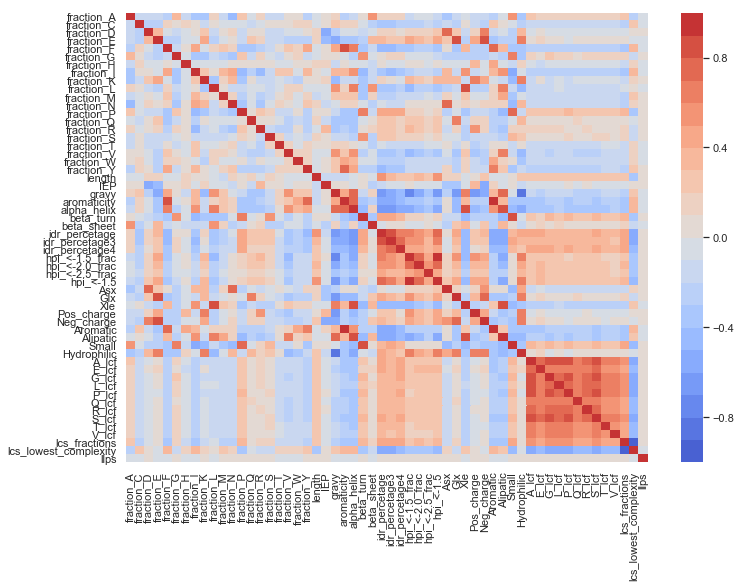

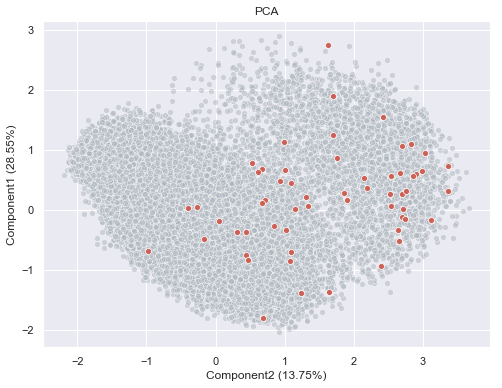

In [12]:
scaler = QuantileTransformer()
df = data.copy()
df = preprocess_data(df, scaler)
df = remove_correlating_features(df, cutoff=.95)
df = remove_low_variance_features(df, variance_cutoff=0.08)
plot_pca(df, title='PCA')

Correlation: Features before 75
Correlation: Features after 68


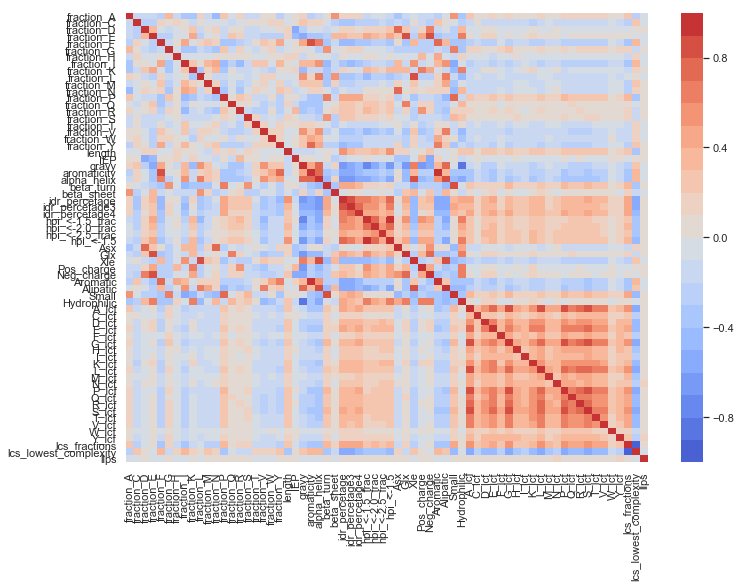

Low varience: Features before 68
Low varience: Features after  58


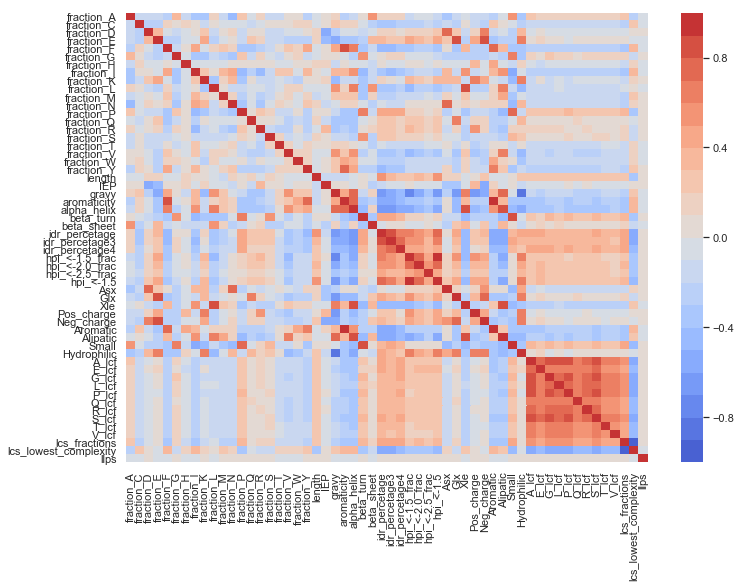

In [13]:
scaler = QuantileTransformer()
df = data.copy()
df = preprocess_data(df, scaler)
df = remove_correlating_features(df, cutoff=.95)
processed_data = remove_low_variance_features(df, variance_cutoff=0.08)

<h1>3. Model selection and evaluation</h1>

<a>https://scikit-learn.org/stable/modules/model_evaluation.html</a>

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier


names = [
    "Gradient Boost",
    "Extra Tres",
    "Nearest Neighbors",
    "Linear SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
]

classifiers = [
    GradientBoostingClassifier(),
    ExtraTreesClassifier(),
    KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.025, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0), max_iter_predict=100),
    DecisionTreeClassifier(max_depth=12),
    RandomForestClassifier(max_depth=12, n_estimators=70),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
]

In [21]:
def get_test_train_indexes(data, instance):
    '''
    Function: When machine learning with more negative instances than positives it will create random testing data
    just like leave on out.
    Dataset this function will iterate so that every negative instance will be used once to train.
    Returns: List with indexes you can train on.
    '''
    positive_instances = set(data.loc[data[instance] == 1].index)
    negative_instances = set(data.loc[data[instance] == 0].index)
    n_positives = data.loc[data[instance] == 1].shape[0]    
    indexes = list()    
    while len(negative_instances) >= 1:    
        if len(negative_instances) > n_positives:
            sample_set = sample(negative_instances, n_positives)
            # l.append((positive_instances, sample_set))
        else:
            sample_set = list(negative_instances)
            size = (len(sample_set))
            short = len(positive_instances) - size        
            shortage = sample(set(data.loc[data[instance] == 0].index), short)
            sample_set = (sample_set+ shortage)
        indexes.append((list(positive_instances) + list(sample_set)))
        negative_instances.difference_update(set(sample_set))
    return(indexes)


def test_train_model(df, clf, instance, testing_size):
    X = df.drop(instance, axis=1)
    # feat_labels = list(X)
    y = df[instance]
    # Split data and fit model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_size, random_state=0)
    clf.fit(X_train, y_train)
    return clf, X_test, y_test


def evaluate_model(data, clf, instance = 'llps', testing_size = 0.4):
    evaluation = {'precision': list(), 'recall': list(), 'f1': list(), 'accuracy': list(),
                  'roc_auc': list(), 'prc_auc': list()
                 }    
    non_numeric_columns = (list(data.select_dtypes(include='object')))
    data = data.select_dtypes([np.number])    
    
    total_y_test = list()
    total_probs = list()
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")            
        index_list = get_test_train_indexes(data, instance)
        for index in index_list:
            df = data.loc[index]
            clf, X_test, y_test = test_train_model(df, clf, instance, testing_size)
            
            # Evaluating model
            y_pred = clf.predict(X_test)
            # print(y_pred)
            prc_auc = get_prc_auc(clf, X_test, y_test, ratio=1, plot=False)
            roc_auc = get_roc_auc(clf, X_test, y_test, plot=False)
            
            
            # Append scores to lists
            evaluation['accuracy'].append(accuracy_score(y_test, y_pred))
            evaluation['precision'].append(precision_score(y_test, y_pred))
            evaluation['recall'].append(recall_score(y_test, y_pred))
            evaluation['f1'].append(f1_score(y_test, y_pred))
            evaluation['roc_auc'].append(roc_auc)
            evaluation['prc_auc'].append(prc_auc)
            
            # Append scores for ROC AUC curves
            
            probs = clf.predict_proba(X_test)
            probs = probs[:, 1]
            total_y_test +=(list(y_test))    
            total_probs += (list(probs))
            
            
    return evaluation, total_y_test, total_probs

<h3>3.1 Evaluate classifiers</h3>

In [22]:
def evaluate_classifiers(df, testsize, instance='llps'):
    probabilities = dict()
    evaluation = pd.DataFrame()
    for name, clf in zip(names, classifiers):
        # print(name)
        out, total_y_test, total_probs = evaluate_model(df, clf, testing_size=testsize)
        for k in out.keys():
            out[k] = np.mean(out[k])
        out['classifier'] = name
        evaluation = evaluation.append(out, ignore_index=True)
        
        # Add probabilities to dictionary
        probabilities[name] = [total_y_test, total_probs]       
    return evaluation, probabilities


def plot_classifier_score_heatmap(evaluation, plot_title=''):
    # Plot heatmap machine learning alrgorithm performances.
    # Set matplotlib parameters
    sns.set(rc={'figure.figsize':(8,6)})
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

    sns.heatmap(evaluation.set_index('classifier').sort_values('recall', ascending=False).round(2),
                annot=True,
                cmap=sns.color_palette("Reds", 20),
                vmin=.76, 
                vmax=1)

    plt.savefig(plot_title, transparent=True)
    
    
def roc_all_classifiers(probabilities, plot_title=''):
    # Set matplotlib parameters
    sns.set(rc={'figure.figsize':(8,6)})
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

    # Plot ROC AUC curves.
    from matplotlib.pyplot import cycler
    plt.plot([0, 1], [0, 1], linestyle='--')
    for k in probabilities.keys():
        total_y_test = probabilities[k][0]
        total_probs = probabilities[k][1]

        #receiving_operation_characteristics(total_y_test, total_probs, k)

        fpr, tpr, thresholds = roc_curve(y_true=total_y_test, y_score=total_probs)
        auc_score = roc_auc_score(total_y_test, total_probs)
        # plot no skill

        # plot the precision-recall curve for the model
        plt.plot(fpr,
                 tpr,
                 #marker='.',
                 label=k +str(auc_score.round(2)),
                )
        plt.legend()
    plt.savefig(plot_title, transparent=True)
    plt.show()

In [23]:
df = processed_data.copy()
evaluation, probabilities = evaluate_classifiers(df, .2, instance='llps')

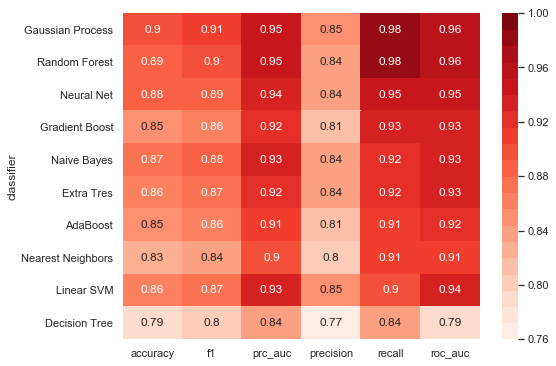

In [29]:
plot_classifier_score_heatmap(evaluation, plot_title='classifier_score_heatmap.pdf')
plt.show()

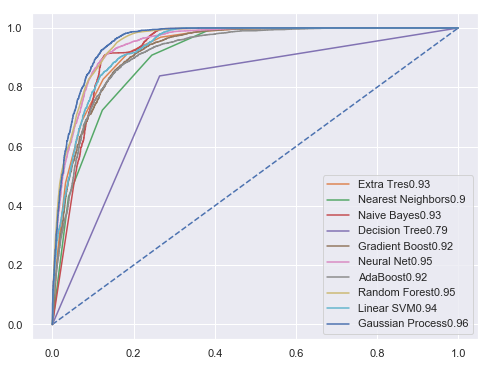

In [28]:
roc_all_classifiers(probabilities, plot_title='receiving_operation_characteristics_all.pdf')

<h3> Randomized machine learning <h3>

In [30]:
df = processed_data.copy()

# Randomize LLPS proteins
df[instance] = 0
for i in list(df.sample(n=58)[instance].index):    
    df.loc[i, instance] = 1
        
random_evaluation, random_probabilities = evaluate_classifiers(df, .2, instance=instance)

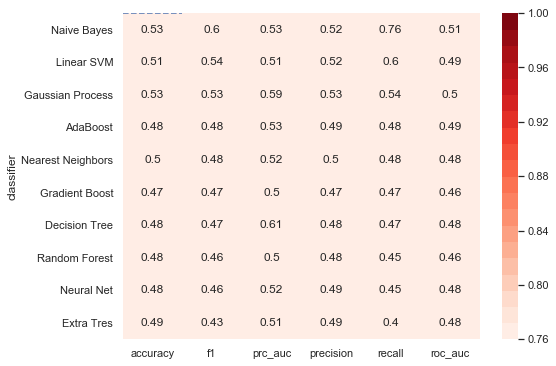

In [35]:
plot_classifier_score_heatmap(random_evaluation, plot_title='classifier_score_heatmap_random.pdf')
plt.show()

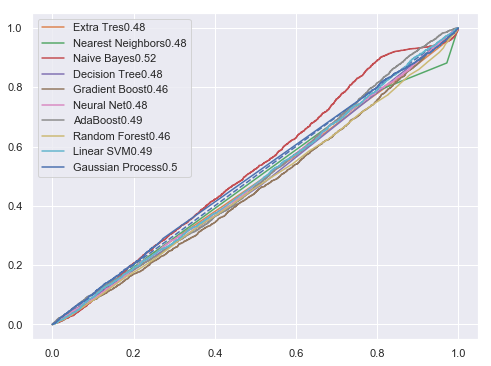

In [38]:
roc_all_classifiers(random_probabilities, plot_title='receiving_operation_characteristics_random.pdf')
plt.show()

<h3>3.3 Cross validate: Precision Recall Curve & Receiving Operating Characteristics</h3>

In [39]:
def get_total_probabilities(data, clf, testing_size):
    non_numeric_columns = pd.DataFrame((list(data.select_dtypes(include='object'))))
    data = data.select_dtypes([np.number])         
    index_list = get_test_train_indexes(data, instance)
    total_y_test = list()
    total_probs = list()

    for index in index_list:
        # Localiza data, and train test.
        df = data.loc[index]
        clf, X_test, y_test = test_train_model(df, clf, instance, testing_size)

        # Evaluating model
        y_pred = clf.predict(X_test)
        probs = clf.predict_proba(X_test)
        probs = probs[:, 1]
        yhat = clf.predict(X_test)   

        # Add probability scores and instance to list.
        total_y_test +=(list(y_test))    
        total_probs += (list(probs))
    return total_y_test, total_probs

df = processed_data.copy()
clf = GaussianProcessClassifier(1.0 * RBF(1.0), max_iter_predict=100)
testing_size=0.2
total_y_test, total_probs = get_total_probabilities(df, clf, testing_size)

<h3> 3.3.1 Precision Recall Curve </h3>

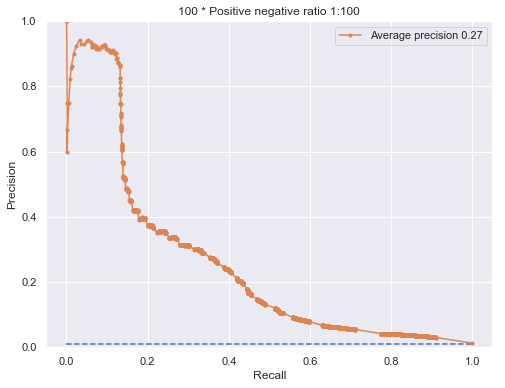

In [40]:
clf = RandomForestClassifier(max_depth=12, n_estimators=70)
ratio=100
cutoff = 1 / (ratio + 1)

total_y_test = list()
total_probs = list()

plt.plot([0, 1], [cutoff, cutoff], linestyle='--')

for i in range(100):
    df = processed_data.copy()
    df, df_info = select_testing_data(df, instance, ratio=ratio-1, info_columns=['protein_name', 'sequence'], random=False)
    
    non_numeric_columns = pd.DataFrame((list(df.select_dtypes(include='object'))))
    df = df.select_dtypes([np.number])         
    index_list = get_test_train_indexes(df, instance)
    clf, X_test, y_test = test_train_model(df, clf, instance='llps', testing_size=.2)
    probs = clf.predict_proba(X_test)
    probs = probs[:, 1]
    yhat = clf.predict(X_test)    
    total_y_test +=(list(y_test))    
    total_probs += (list(probs))
    
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(total_y_test, total_probs)
avg_precision = average_precision_score(y_test, probs)

# Set matplotlib parameters
sns.set(rc={'figure.figsize':(8,6)})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42    

# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.',
         label='Average precision %0.2f' % avg_precision)
plt.legend()

# Plot labels

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('100 * Positive negative ratio 1:100')

plt.ylim(0,1)
plt.savefig('precision_recall_curve.pdf', transparent=True)
plt.show()

<h3>3.3.2 10K Cross validation</h3>

In [41]:
from sklearn.model_selection import StratifiedShuffleSplit
instance='llps'

clf = RandomForestClassifier(max_depth=12, n_estimators=70)
df = processed_data.copy()


# Get random dataset with positive: 58, negative: 5742
df, _ = select_testing_data(df, instance, ratio=100-1, info_columns=['protein_name', 'sequence'], random=False)


X = df.drop(instance, axis=1)
y = df[instance]


total_y_test = list()
total_probs = list()


sss = StratifiedShuffleSplit(n_splits=10, test_size=.1, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:, 1]
    yhat = clf.predict(X_test)    
    total_y_test +=(list(y_test))    
    total_probs += (list(probs))

    
# Receiving Operating Characteristics
fpr, tpr, thresholds = roc_curve(y_true=total_y_test, y_score=total_probs)
auc_score = roc_auc_score(total_y_test, total_probs)


# Plot lines
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr,
         tpr,
         marker='.',
         label='Area ' +str(auc_score.round(2)),
        )

# Plot titles and legends
plt.title('10K cross validation (Positive:Negative 1:100)')
plt.ylabel('Sensitivity')
plt.xlabel('Specificity')
plt.legend()

# Set matplotlib parameters
sns.set(rc={'figure.figsize':(8,6)})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.savefig('10K_cross_validation.pdf', transparent=True)

<h3>3.3.3 Cross validate: Leave one out</h3>

In [42]:
def receiving_operation_characteristics(total_y_test, total_probs, plot_title=''):
     # Set matplotlib parameters
    sns.set(rc={'figure.figsize':(8,6)})
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    
    fpr, tpr, thresholds = roc_curve(y_true=total_y_test, y_score=total_probs)
    auc_score = roc_auc_score(total_y_test, total_probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(fpr, tpr, marker='.',
             label='ROC curve (area = %0.2f)' % auc_score)
    # add labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend(loc="lower right")
    # sns.despine()
    # show the plot
    plt.savefig(plot_title.lower().replace(' ','_')+'_ROC'+'.pdf', transparent=True)
    plt.show()


def combined_leave_one_out(df, clf, testing_size):
    non_numeric_columns = pd.DataFrame((list(df.select_dtypes(include='object'))))
    data = df.select_dtypes([np.number])         
    index_list = get_test_train_indexes(data, instance)

    total_y_test = list()
    total_probs = list()

    for index in index_list:
        # Localiza data, and train test.
        df = data.loc[index]
        df = shuffle(df, random_state=0)
        X = df.drop(instance, axis=1)
        y = df[instance]
        loo = LeaveOneOut()
        loo.get_n_splits(df)

        for train_index, test_index in loo.split(df):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]        
            clf = clf.fit(X_train, y_train)        
            total_y_test.append(y_test.iloc[0])        
            total_probs.append(clf.predict_proba(X_test)[0][1])
    return total_y_test, total_probs

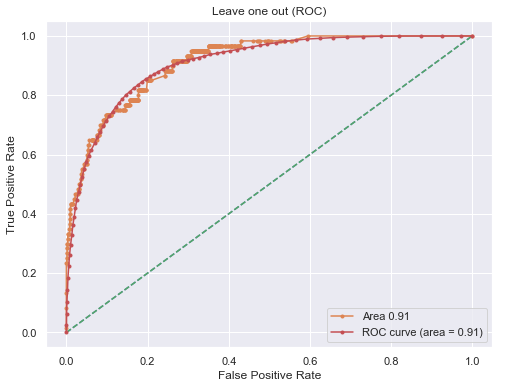

In [ ]:
# ! This takes pretty long.. 368 * 116 (42688) random forrests in total.

df = processed_data.copy()
clf = RandomForestClassifier(max_depth=12, n_estimators=70)
testing_size=0.2
total_y_test, total_probs = combined_leave_one_out(df, clf, testing_size)

#Plots the curves
receiving_operation_characteristics(total_y_test, total_probs, plot_title='Leave one out (ROC)')

<h3>3.4 Establish cutoff value</h3>

In [ ]:
def find_optimal_cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations
    predicted : Matrix with predicted data, where rows are observations
    Returns
    -------     
    list type, with optimal cutoff value
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 


optimal_cutoff = find_optimal_cutoff(probabilities['Random Forest'][0], probabilities['Random Forest'][1])
print(optimal_cutoff)

[0.6285714285714286]


<h1>4. Use method to predict phase separating proteins</h1>

<h3>4.1 Model</h3>

In [ ]:
clf = RandomForestClassifier(max_depth=12, n_estimators=70)

<h3>4.2 Prediction of the proteome</h3>

In [ ]:
def predict_proteome(df, clf, instance, testing_size, feature_imp=True, predict_training=False):
    pd.set_option('mode.chained_assignment', None)
    prediction = df.select_dtypes(include='object')
    df = df.select_dtypes([np.number])    
    indexes = get_test_train_indexes(df, instance)
    count = 0 
    
    fi_data = None
    for index in indexes:
        df_fraction = df.loc[index]        
        # Also consider X_test index for prediction in the proteome
        clf, X_test, y_test = test_train_model(df_fraction, clf, instance, testing_size)
        
        # Feature importance
        if feature_imp:        
            X = df_fraction.drop('llps', axis=1)
            fi = clf.feature_importances_
            fi = pd.DataFrame(fi).transpose()
            fi.columns = X.columns
            fi = fi.melt()
            fi = fi.sort_values('value', ascending=False) 
            if fi_data is None:
                fi_data = fi            
            else:
                fi_data = pd.merge(fi_data, fi, on='variable')
            
        
        # Make prediction dataframe.
        probability = clf.predict_proba(df.drop(instance, axis=1))[:, 1]      
        prediction['probability_'+str(count)] = probability
        
        # Removing prediction that were used in the train test set.
        if not predict_training:            
            for i in index:
                prediction.loc[i, 'probability_'+str(count)] = np.nan        
        count += 1
    if feature_imp:
        return prediction , fi_data
    else:
        return prediction

<h3>4.2.1 Make prediction with random forest</h3>

In [ ]:
# Make prediction
prediction, fi_data = predict_proteome(processed_data, clf, instance='llps', testing_size=.2, predict_training=True)
# Save prediction to .csv
prediction.to_csv('prediction_randomforrest_051219.csv')

<h3>4.2.2 Make prediction with Gaussian Process</h3>

In [ ]:
prediction = predict_proteome(processed_data,
                                       GaussianProcessClassifier(1.0 * RBF(1.0), max_iter_predict=100),
                                       instance='llps',
                                       testing_size=.2,
                                       feature_imp=False
                                      )
# Save prediction to .csv
prediction.to_csv('prediction_gaussian_051219.csv')

<h3>4.2.3 Make prediction with training set</h3>

In [ ]:
prediction, fi_data = predict_proteome(processed_data, clf, instance='llps', testing_size=.2, predict_training=True)

<h3>4.2.4 Add: 'protein name' and 'uniprot_id' to prediction and save</h3>

In [ ]:
prediction['mean'] = prediction.select_dtypes([np.number]).mean(axis=1)
prediction['llps'] = data['llps']
raw = pd.read_pickle(path)
prediction = pd.merge(prediction[['protein_name', 'mean', 'llps']], raw[['protein_name', 'uniprot_id']], on='protein_name')
del raw
raw_prediction = prediction.copy()
prediction = prediction.sort_values('mean', ascending=False).reset_index(drop=True)
prediction.to_csv('Prediction_random_forest_051219.csv')

In [ ]:
prediction.to_csv('Prediction_random_forest_051219.csv')
# prediction.to_csv('mean_prediction_randomforest.csv')

In [ ]:
prediction = pd.read_csv('Prediction_random_forest_051219.csv', index_col=0)

In [ ]:
prediction = prediction.loc[prediction['llps'] == 0]

In [ ]:
prediction.loc[prediction['mean'] > optimal_cutoff].shape[0]

1950

In [ ]:
','.join(list(prediction.loc[prediction['mean'] >= optimal_cutoff]['uniprot_id']))
','.join(list(prediction.loc[prediction['mean'] >= .8]['uniprot_id']))

'Q99729,O43390,Q14011,Q8ND56,P04264,P14866,O75190,O60506,Q9BUJ2,P51116,O95104,Q12906,Q16630,Q5JVS0,O94913,Q8NC51,Q00839,Q14103,Q9BX40,Q86V81,Q9HCD5,O15117,Q8TEW0,Q9UPY6,Q96E39,P35527,P17600,O75526,Q13243,P35908,Q14444,Q13247,P67809,Q9UGU0,P18615,Q96QZ7,Q96JK9,Q9BYJ9,O00401,Q9UPT8,O14497,Q7Z739,Q92997,P38159,Q14157,Q96EP5,P62995,Q9NVW2,Q8IXF0,Q9UKM9,Q9NY12,Q68D10,Q5BKZ1,Q6PKG0,P55808,Q86UL8,Q8NFD5,O14654,Q5VT52,Q07666,Q9UBL0,Q96QC0,Q8WWM7,Q86VY4,P12110,P40425,O15504,Q9P2N5,Q13595,Q14004,Q8N684,Q9Y6W5,Q9P2K5,Q96AE4,P52756,Q6E0U4,Q9Y2W2,Q86XP3,Q9Y2K5,Q92734,Q5JU85,Q8IWX8,Q3YEC7,Q5T6F2,O15042,Q9NSY1,P50607,Q9Y6Q9,Q96N64,P13645,Q9Y2J0,P16989,Q9UDY2,Q15032,Q86U06,Q8NCA5,Q9UBB5,P61129,P55316,Q12948,O14994,O43823,P02671,Q9C0J8,Q9Y2W1,P35269,Q7Z6E9,O75175,Q9UHB7,Q92922,Q00577,Q7Z417,Q9BRR8,Q6UN15,Q5TF21,Q9Y5A9,Q96EV2,Q9NYF8,Q92945,Q9BXP5,O15047,Q10571,Q12872,O14641,O75494,Q96T37,O00294,Q86U42,P23588,A6NHQ2,P98082,Q13435,Q2UY09,Q9Y520,P78332,Q8TAQ2,Q96DT7,P20073,Q8IZL2,Q9NS56,Q96JC9,Q99856,Q9NQS

Final prediction<br>
Q99729,O43390,Q14011,Q8ND56,P04264,O75190,P14866,Q9BUJ2,P51116,O60506,O95104,Q12906,Q16630,O94913,Q00839,Q14103,Q5JVS0,Q8NC51,Q86V81,Q9BX40,Q9HCD5,O15117,Q96E39,Q9UPY6,P17600,Q13243,P35527,O75526,Q8TEW0,P67809,Q13247,Q14444,P35908,Q96QZ7,O00401,Q9BYJ9,Q9UPT8,Q7Z739,P38159,Q8IXF0,P62995,Q92997,O14497,Q9UGU0,P18615,Q96EP5,Q9NVW2,Q96JK9,Q14157,Q86UL8,Q5BKZ1,Q68D10,Q13595,P40425,Q07666,Q9UKM9,P12110,Q8NFD5,Q9NY12,Q96QC0,Q9UBL0,Q6PKG0,P55808,Q3YEC7,O14654,Q86XP3,Q9Y6W5,Q8WWM7,Q5VT52,Q14004,Q96AE4,Q8N684,Q9P2K5,Q5JU85,Q9P2N5,Q9Y2J0,Q9Y2K5,Q86VY4,Q6E0U4,Q9Y2W2,P61129,Q92734,P16989,O15504,P52756,Q96N64,Q9NSY1,Q9UDY2,P55316,Q8NCA5,P50607,Q8IWX8,Q5T6F2,Q7Z417,O75175,Q86U06,Q9UHB7,O14994,Q12948,P02671,Q9Y2W1,Q9Y5A9,P13645,O43823,Q15032,Q9NYF8,O15042,Q7Z6E9,Q9BRR8,Q92922,Q92945,O75494,Q9Y6Q9,Q00577,Q9C0J8,Q9UBB5,Q9NQ76,O14641,P35269,Q8TAQ2,Q96T37,Q86U42,P98082,Q96EV2,Q6UN15,O15047,O15234,Q12872,Q9BRL6,Q5TF21,Q96DT7,P23588,Q17RY0,Q96JC9,Q2UY09,P20073,O00294,P78332,Q9BXP5,Q10571,P12109,A6NHQ2,Q13435,P49750,Q14677,A6NHN0,P12107,Q9H7E2,Q9BWW4,Q9UKJ3,Q99856,Q15427,Q99967,Q96HR8,B2RXH8,P0DMR1,B7ZW38,Q9NS56,Q5T8P6,Q02078,Q8NHS0,P51532,P25440,Q9BUV0,Q6PJG2,Q9Y520,O15523,P09038,O95835,Q8IZL2,Q96DH6,Q8TF01,Q9UKL0,Q8WXX7,Q9NQS1,Q92777,Q9UPN6,Q15637,Q8N2M8,Q9BQI5,Q5TCY1,Q5TC84,Q9ULX6,Q03111,Q5JSZ5,Q9Y2T7,Q9Y2X9,Q8N5F7,Q16629,Q08170,Q9BTC0,Q8IXT5,P61978,Q07157,Q13427,O15265,Q92541,Q9P0K8,Q6NWY9,Q8NDT2,Q9P2D1,P19622,Q8N4C8,Q01546,Q9UBV8,Q15672,D6RIA3,Q9Y6X0,Q15059,P35568,Q14993,Q9UI08,O95429,Q96MU7,Q96G74,A6NDE4,Q9BRD0,Q96MF2,O00267,P50502,Q9ULD9,Q8N7H5,Q9UKY7,Q15415,P08621,Q96PV6,Q9P270,Q9NUL3,P08123,Q9BXJ5,Q8WUQ7,P07910,O43516,P42568,Q9NWH9,P84103,Q9BQ61,Q5JWF2,Q8N8S7,Q9HDC5,Q9UMD9,Q9NRM1,O75177,Q86X95,Q9HC52,Q9NYV4,A0A1B0GUY1,Q8TAD8,O15014,P20908,Q5VTL8,Q9H9J4,Q09472,Q96IZ0,Q15424,Q8NE35,Q9UPQ9,Q9P2R6,Q9UMZ2,Q9Y3E1,Q9C0B9,P51114,Q5T481,Q14151,Q9Y5R6,O14511,Q8NDV7,Q92841,O75376,P55197,Q969W3,P12035,O60812,Q03692,Q9ULJ6,Q92794,Q9Y618,P0C7P1,Q15532,P0DJD3,P35611,P0DJD4,Q14774,Q96QR8,A6NEQ0,Q13950,P13942,O75400,Q9NYB9,Q8NFW1,Q5TCZ1,Q8TB72,Q53FD0,Q5VUA4,P83369,Q96S59,Q8WVK2

<h3>4.3 Plot distribution of probabilities</h3>

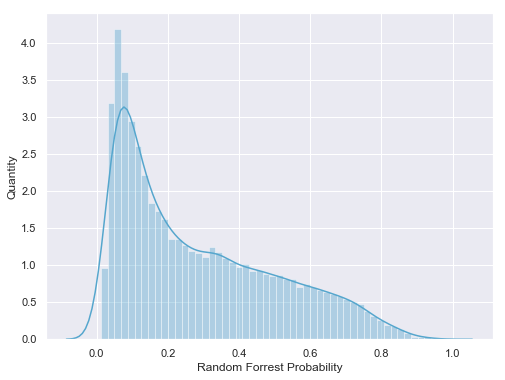

In [ ]:
# Set matplotlib parameters
sns.set(rc={'figure.figsize':(8,6)})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Plot and save figure
sns.distplot(prediction.loc[prediction['llps'] == 0]['mean'], bins=50, color = '#55a6cd')
plt.xlabel('Random Forrest Probability')
plt.ylabel('Quantity')
plt.draw()
# plt.savefig('histogram_prediction.pdf', transparent=True)
plt.show()

<h3>4.4 Feature importances</h3>

In [ ]:
fi_data['mean'] = fi_data.select_dtypes([np.number]).mean(axis=1)
fi_data = fi_data.sort_values('mean', ascending=False).reset_index(drop=True)
fi_data[['variable', 'mean']]

,variable,mean
0,Xle,0.071913
1,fraction_L,0.071752
2,Alipatic,0.057462
3,alpha_helix,0.051733
4,lcs_fractions,0.048768
5,fraction_C,0.043014
6,gravy,0.042006
7,beta_turn,0.039537
8,idr_percetage,0.036617
9,fraction_W,0.026087


In [ ]:
# Set matplotlib parameters
sns.set(rc={'figure.figsize':(8,6)})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fi_data[0:10].plot.bar(x='variable', y='mean', rot=45, color='#CD6155')
plt.ylabel('Fraction of impact')
plt.xlabel('Feature')
plt.title('Mean feature importances')
# plt.savefig('feature_importances.pdf', transparent=True)

alpha_helix =  V, I, Y, F, W, L <br>
gravy = 'hydropathic character of a protein' https://www.ncbi.nlm.nih.gov/pubmed/7108955?dopt=Abstract

<h1>5. Visualize prediction<h1>

In [ ]:
def dimension_reduction_plot(df, probability=.8, title='', hue_column='mean'):
    # Set matplotlib parameters
    sns.set(rc={'figure.figsize':(11.7,8.27),
               'axes.facecolor':'#AEB6BF',
               'figure.facecolor':'#AEB6BF'})
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42


    sns.scatterplot(data=df.loc[df['llps'] == 0],
                    x = 'component1',
                    y = 'component2',
                    alpha=.1,
                    color='#AEB6BF',
                    rasterized=True,
                   )
    sns.set_palette("Reds")
    sns.scatterplot(data=df.loc[df[hue_column] >= probability],
                    x = 'component1',
                    y = 'component2',
                    hue='mean',
                    alpha=.3,
                    palette='Blues',
                    rasterized=True,
                    )
    sns.scatterplot(data=df.loc[df['llps'] == 1],
                    x = 'component1',
                    y = 'component2',
                    alpha = 1,
                    color = '#CD6155',   
                    )
    
    plt.title(title)
    if title != '':
        plt.savefig(title+'_'+str(probability)+'.pdf', transparent=True)
    plt.show()

<h3> UMAP </h3>

pip install umap-learn (Check version with Jurriaan)

In [ ]:
import umap
df = processed_data.copy()
X = df.drop(['sequence', 'protein_name', 'llps'],axis=1)

fit = umap.UMAP()
%time u = fit.fit_transform(X)

X_umap = pd.DataFrame(u, columns=['component1', 'component2'])
X_umap = pd.DataFrame(X_umap, columns=['component1', 'component2'])
X_umap['protein_name'] = df['protein_name']
X_umap['llps'] = df.reset_index()['llps']
X_umap['mean'] = raw_prediction['mean']

ImportError: No module named 'umap'

In [ ]:
X_umap.to_csv('umap_data_051219.csv')

In [ ]:
X_umap = pd.read_csv('umap_data_051219.csv', index_col=0)

In [ ]:
dimension_reduction_plot(X_umap, probability=.0, title='umap prediction')

<h3>Map shit to UMAP</h3>

In [ ]:
def get_interpro_data(path, filter_list):
    df = pd.read_csv(path, delimiter='\t')
    df = df.loc[df[filter_list[0]].isin(filter_list[1])]
    # new data frame with split value columns 
    new = df["Protein Accession"].str.split("|", expand = True) 

    # making separate first name column from new data frame 
    df["uniprot_accession"]= new[1] 

    # making separate last name column from new data frame 
    df["protein_name"]= new[2] 

    # Dropping old Name columns 
    df.drop(columns =["Protein Accession"], inplace = True)
    df['RRM']  ='1'
    df = df[['protein_name', 'RRM']]
    df = df.drop_duplicates()
    print(df.shape)
    return df


def plot_interpro_on_umap(df):
    # Set matplotlib parameters
    sns.set(rc={'figure.figsize':(11.7,8.27),
               'axes.facecolor':'#AEB6BF',
               'figure.facecolor':'#AEB6BF'})
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    
    df = pd.merge(X_umap, df, on='protein_name', how='outer').fillna(0)
    df['RRM'] = df['RRM'].astype('int64')

    # Scatterplot
    sns.scatterplot(data=df,
            x = 'component1',
            y = 'component2',
            hue='mean',
            alpha=.3,
            palette='Blues',
            rasterized=True,
            )
   

    sns.scatterplot(data=df.loc[df['RRM'] == 1],
                    x = 'component1',
                    y = 'component2',
                    alpha = 1,
                    color = '#000000',
                    marker="+",
                    )
    sns.scatterplot(data=df.loc[df['llps'] == 1],
                    x = 'component1',
                    y = 'component2',
                    alpha = 1,
                    color = '#CD6155',   
                    )
    plt.savefig('umap_RRM.pdf', transparent=True)

    
    
def plot_interpro(filter_list):
    path = '/home/jurriaan/jupyter/Phase Separation Pipeline/data/uniprot_reviewed_interpro_051219.tsv'
    df = get_interpro_data(path, filter_list)
    plot_interpro_on_umap(df)

In [ ]:
RRM_PFAM = ['Signature Accession',['PF00076']]
plot_interpro(RRM_PFAM)

In [ ]:
df = pd.merge(X_umap, processed_data, on=['protein_name', 'llps'])

In [ ]:
for i in list(df._get_numeric_data()):
    # Set matplotlib parameters
    sns.set(rc={'figure.figsize':(11.7,8.27),
               'axes.facecolor':'#AEB6BF',
               'figure.facecolor':'#AEB6BF'})
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    sns.scatterplot(data=df,
                    x = 'component1',
                    y = 'component2',
                    hue=i,
                    alpha=.3,
                    palette='Blues',
                    rasterized=True,
                    )
    plt.title(i)
    # plt.savefig('UMAP/umap_'+i+'.pdf', transparent=True)
    plt.show()